Goal: interpret the model in a white-box fashion, looking inside the model at the learned filters and analyzing saliency maps for what positions and nucleotides matter most towards functional characteristics.

In [1]:
# import statements 

import os

import platform
import random
import shutil
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras
%matplotlib inline

# some visualization imports
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
import logomaker as lm

# various imports for the keras model
from keras.layers.core import Permute
from keras import backend as K
from keras.engine.topology import Layer
import keras as keras
#from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv1D, Concatenate
from keras.optimizers import SGD
from keras.regularizers import l2

# evaluate performance w/ on and off regression separately 
from scipy.stats import pearsonr, spearmanr 

# imports for the grid search and kfold CV
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

# data one-hot encoding imports
from pysster.One_Hot_Encoder import One_Hot_Encoder
from sklearn import preprocessing
from keras.utils import to_categorical

import matplotlib
import matplotlib.font_manager as fm
fpath = '/Library/Fonts/Myriad-Pro_31655.ttf'
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]
axis_font = {'fontname':fname, 'fontproperties':prop}

Using TensorFlow backend.


# Part 1. Load in final model. 

In [2]:
from tensorflow.keras.models import load_model

output_dir = 'trained_model/'
final_model_path = output_dir + 'final_trained_model.h5'
final_weights_path = output_dir + 'final_trained_model_weights.h5'
model = load_model(final_model_path)
model.load_weights(final_weights_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [3]:
# visually check architecture
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 59, 4)        0                                            
__________________________________________________________________________________________________
conv_0 (Conv1D)                 (None, 59, 10)       210         input_2[0][0]                    
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 59, 5)        155         conv_0[0][0]                     
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 295)          0           conv_1[0][0]                     
__________________________________________________________________________________________________
dropout_4 

# Part 2. Visualize learned filters. From first layer convolution. 
NOTE: the first convolutional layer is the only layer that operates directly on the one-hot encoded sequence. Has a more straightforward possible mapping back to motifs/partial motifs.

In [4]:
# extract first 1d conv layer
conv1 = model.layers[1]

# get filter weights and bias weights
fw, bw = conv1.get_weights()
print('filter weight matrix shape: ', fw.shape)

logos=[]

alph_letters = sorted('AUCG')
alph = list(alph_letters)

filter weight matrix shape:  (5, 4, 10)


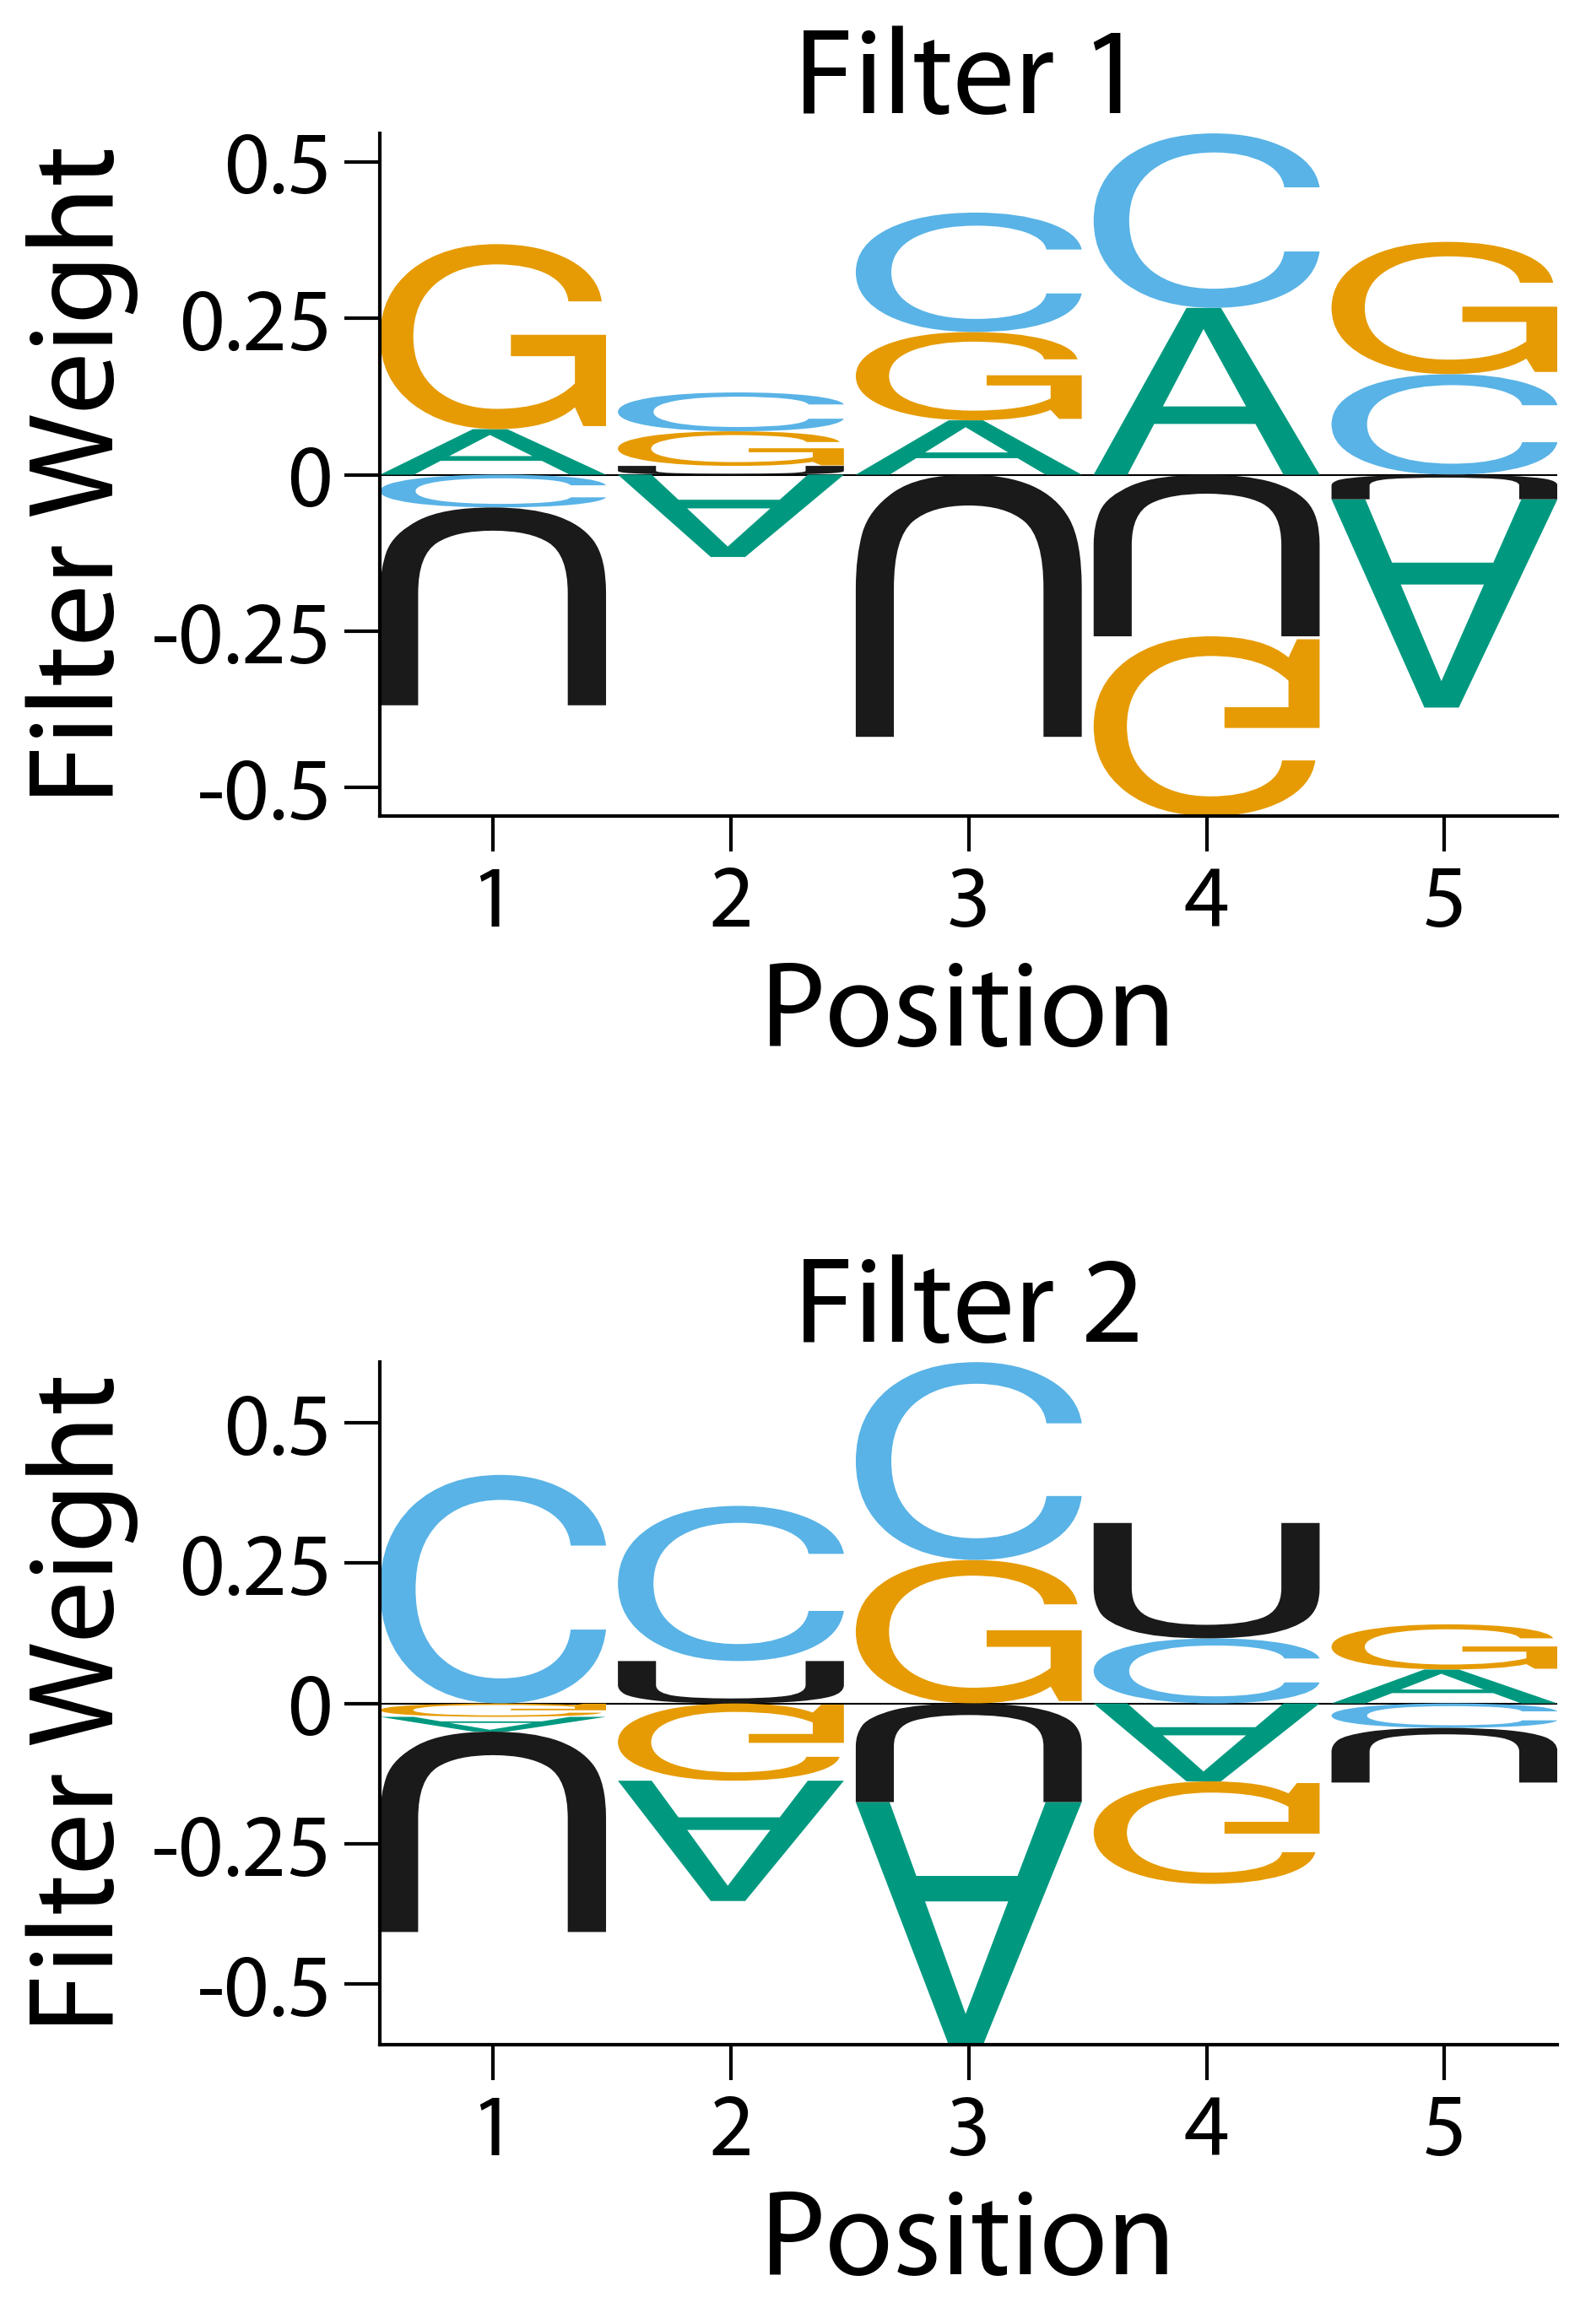

In [5]:
fig, axs = plt.subplots(2,1, figsize=(6, 10), dpi = 300)
fig.subplots_adjust(hspace = 0.8, wspace=.5)

axs = axs.ravel()

for filt_idx in range(2): 
    filt_weight_df = pd.DataFrame(fw[:,:,filt_idx], columns=alph)
    logo = lm.Logo(filt_weight_df,ax=axs[filt_idx], font_name='Microsoft Sans Serif', center_values = True, vpad = 0, 
                   color_scheme = 'colorblind_safe', show_spines = False, flip_below = True)
    
    axs[filt_idx].spines['bottom'].set_visible(True)
    axs[filt_idx].spines['left'].set_visible(True)
    axs[filt_idx].set_xticklabels([0, 1, 2, 3, 4, 5], **axis_font, fontsize = 25)
    
    ylabels = axs[filt_idx].get_yticks()
    ytickmax = max(ylabels)
    ytickmin = min(ylabels)
    
    axs[filt_idx].set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
    axs[filt_idx].tick_params(length = 10, width = 1)
    axs[filt_idx].set_yticklabels([-0.5, -0.25, 0, 0.25, 0.5], **axis_font, fontsize = 25)   
    
    axs[filt_idx].set_xlabel('Position', **axis_font, fontsize = 35)
    axs[filt_idx].set_ylabel('Filter Weight', **axis_font, fontsize = 35)
    axs[filt_idx].set_title('Filter ' + str(filt_idx + 1), **axis_font, fontsize = 35 )
    logos.append(logo)